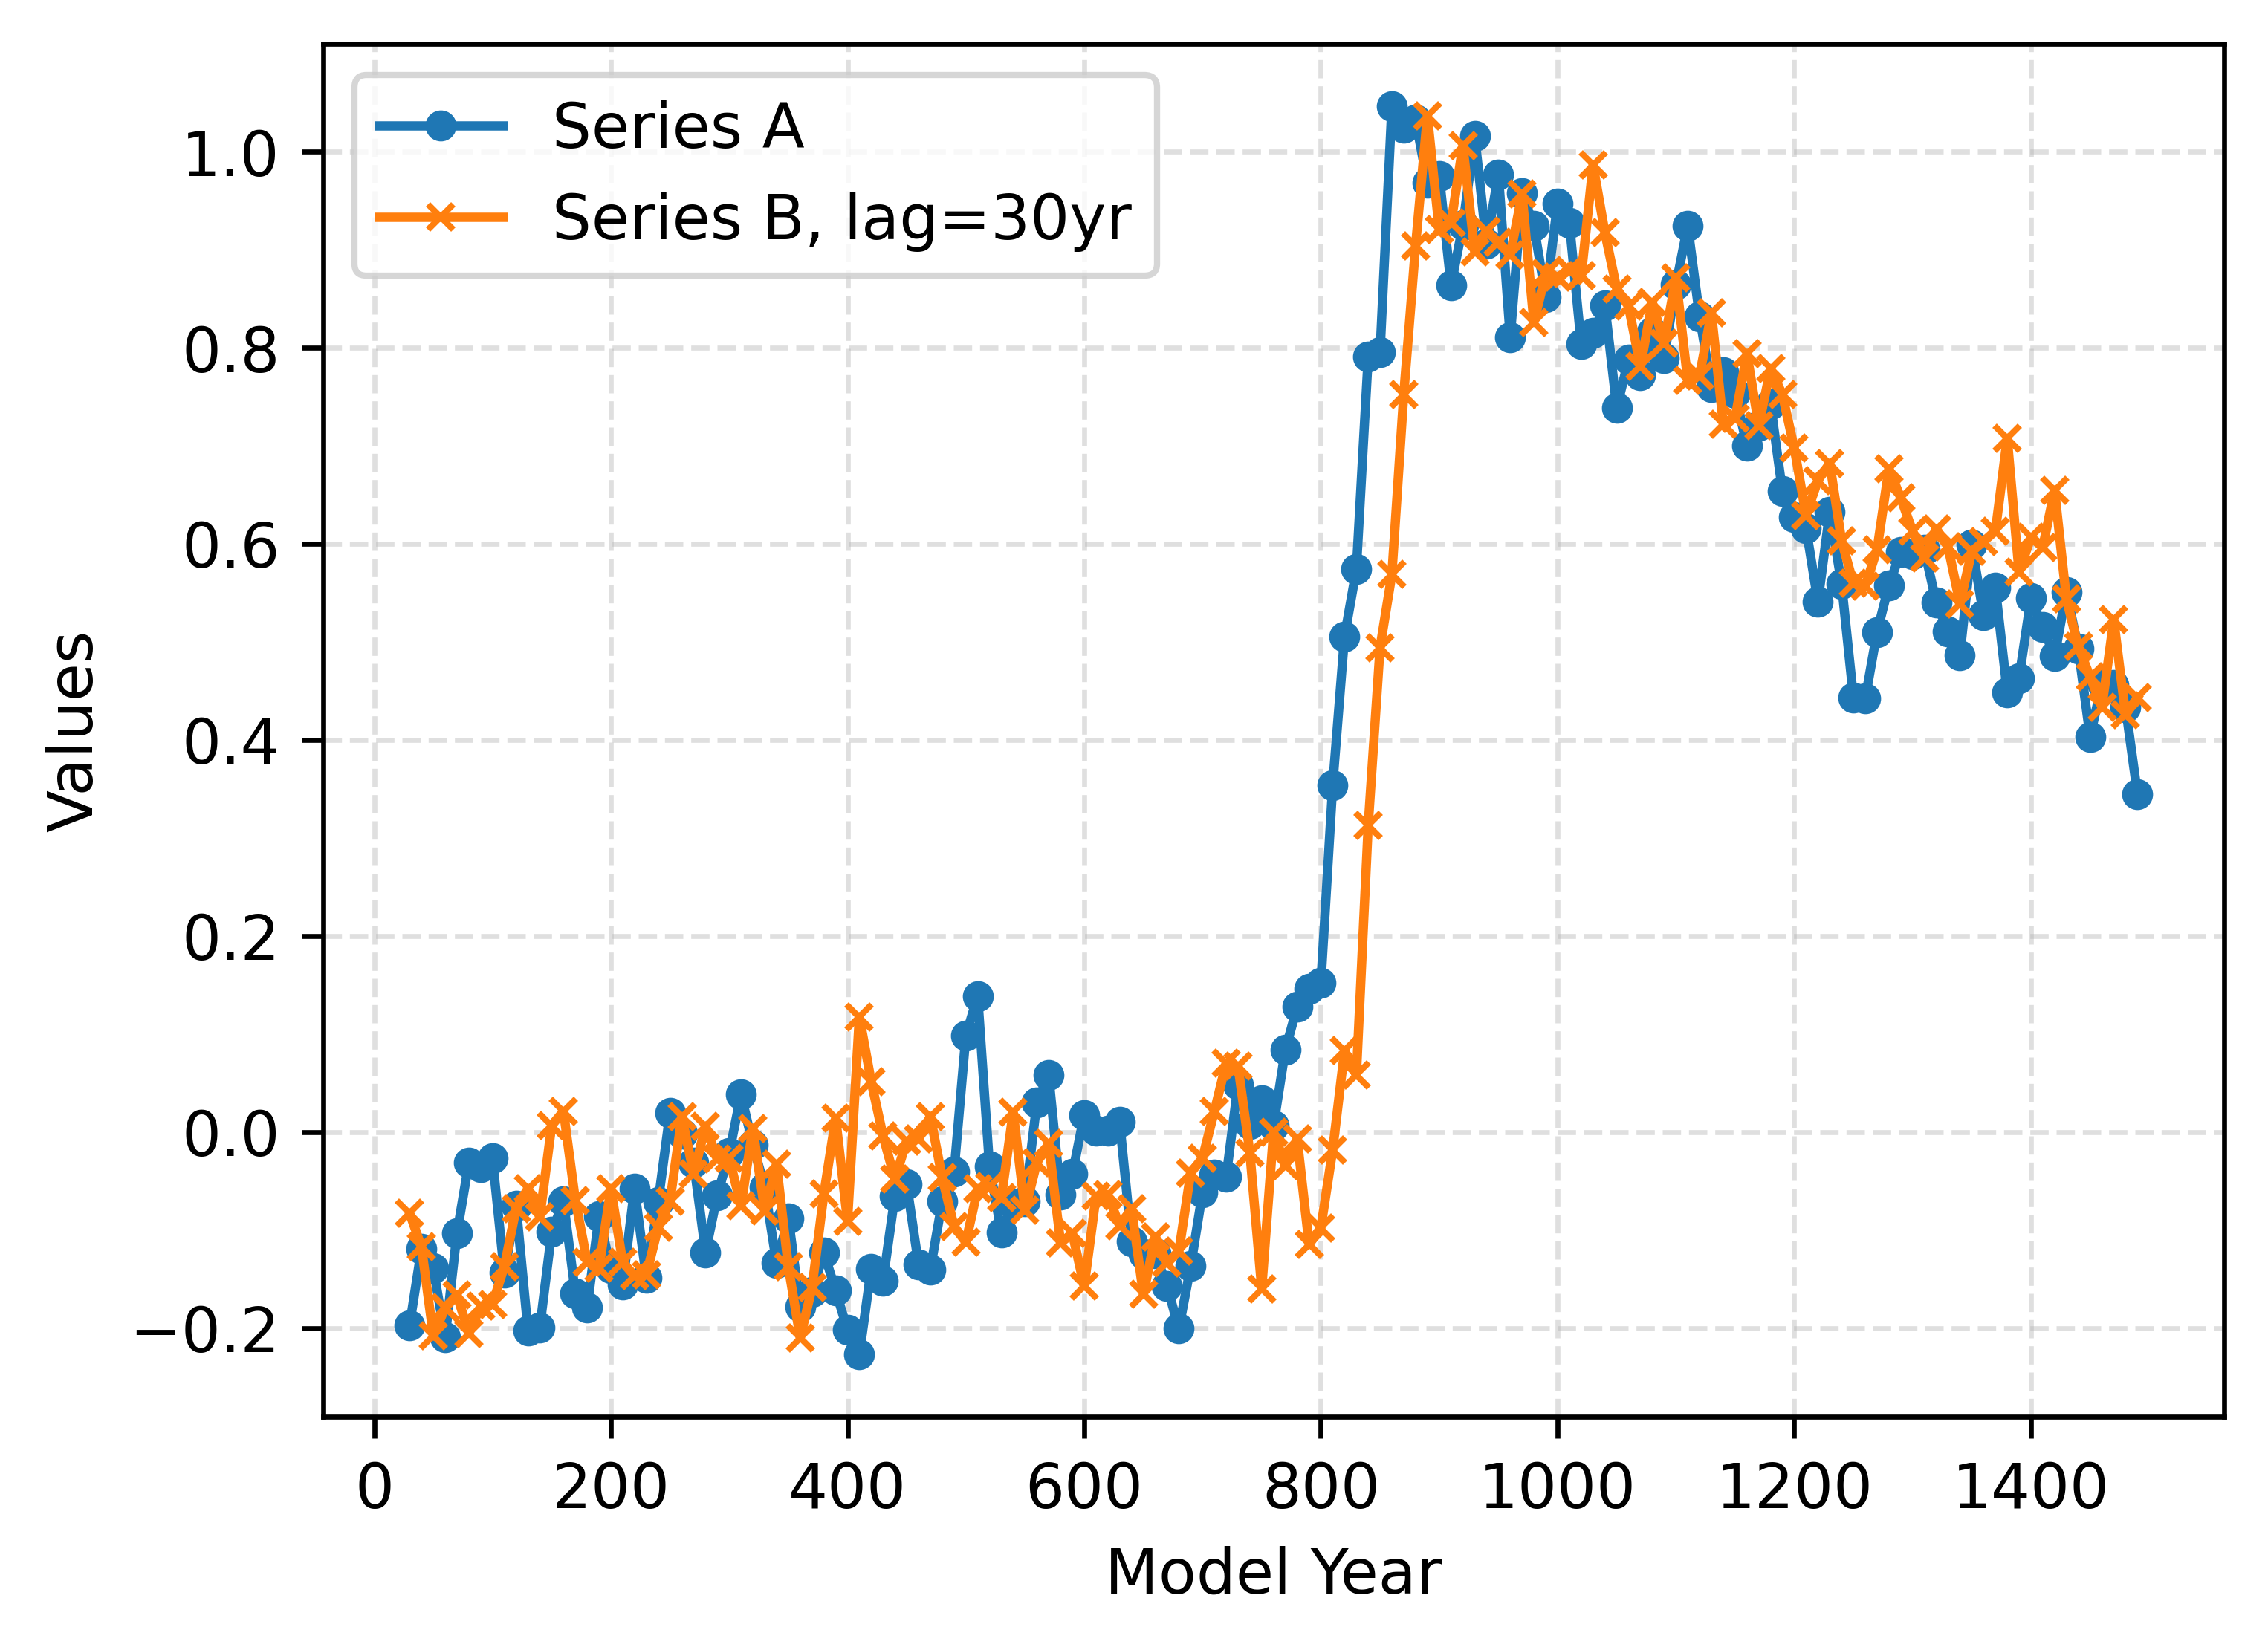

In [1]:
import matplotlib.pyplot as plt
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)


lag=-3
dummy_data = saf.gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
data = saf.gen_linked_data(dummy_data, causal_strength=1, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)

# data = saf.gen_single_directional_data(length=1500, delta=10.0, lag=lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=5e-5, sigma=0.05)
# Enhance the plot
plt.figure(figsize=(5.5, 4),dpi=600)  # Adjust the figure size
plt.plot(data['time'], data['A'], label='Series A', linestyle='-', marker='o', markersize=4)
plt.plot(data['time'], data['B'], label=f'Series B, lag={lag*-10}yr', linestyle='-', marker='x', markersize=4)

# Add grid, title, and labels
plt.grid(True, linestyle='--', alpha=0.4)
# plt.title('Time Series of Dummy Warming Data')
plt.xlabel('Model Year')
plt.ylabel('Values')

# Add legend
plt.legend()

plt.show()


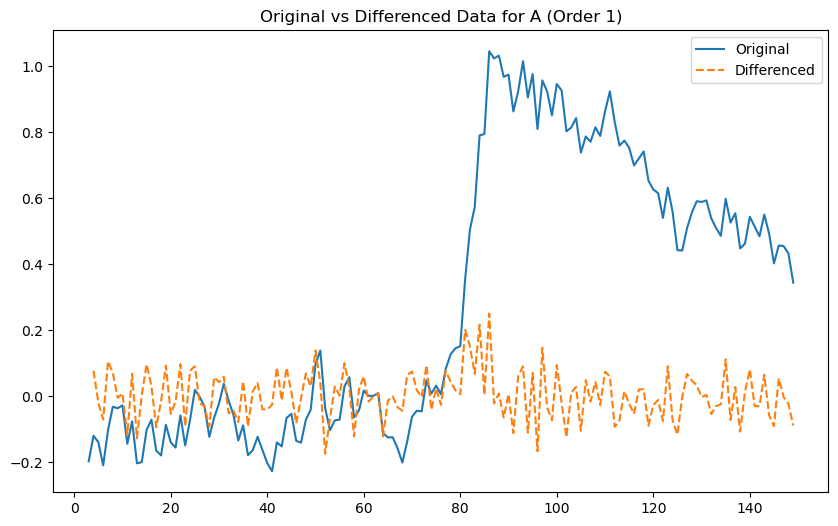

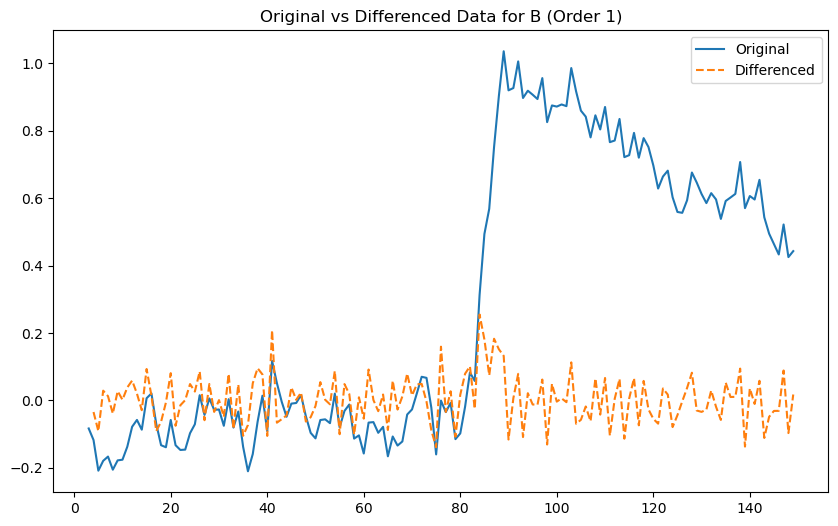

In [2]:
from toolbox import GC_functions as GC
import importlib
importlib.reload(GC)

df_AB_sta = GC.make_stationary(data,['A', 'B'], test_method='ADF', plot=True)


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='A'>, <Axes: ylabel='B'>], dtype=object))

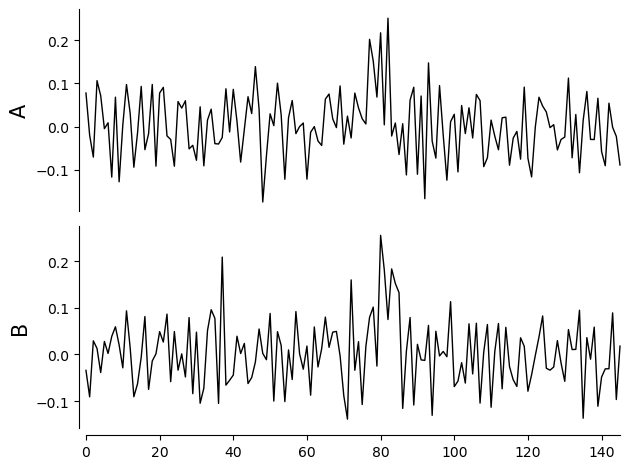

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn


# get the column of A and B from the dataframe and convert to numpy array
AB_array = df_AB_sta[['A', 'B']].values

var_names=['A', 'B']
# Create a Tigramite DataFrame object
dataframe_sta = pp.DataFrame(AB_array,
                         datatime=np.arange(len(AB_array)),
                         var_names=var_names)

tp.plot_timeseries(dataframe_sta,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable A has 0 link(s):
    [pc_alpha = 0.05]

    Variable B has 3 link(s):
    [pc_alpha = 0.2]
        (A -3): max_pval = 0.00011, |min_val| =  0.325
        (A -2): max_pval = 0.00061, |min_val| =  0.288
        (A -4): max_pval = 0.12549, |min_val| =  0.132

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -3): pval = 0.00011 | val =  0.326
        (A -2): pval = 0.00061 | val =  0.290
        (B -1): pval = 0.00795 | val = -0.228


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

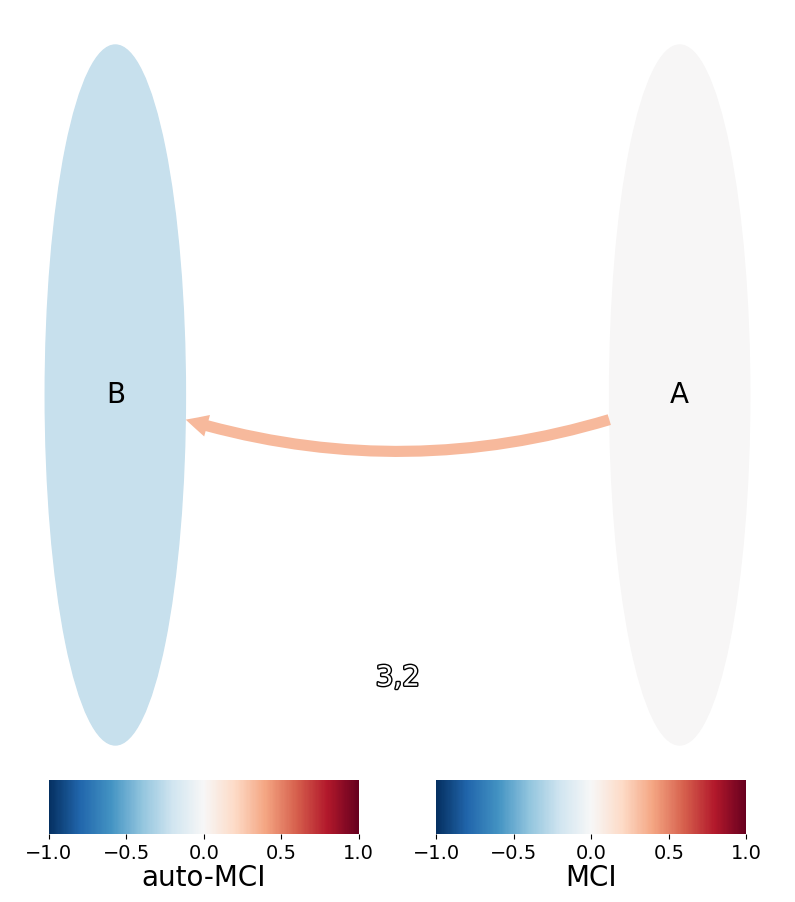

In [7]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_sta,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=4
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=20,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
    )

(<Figure size 650x650 with 1 Axes>, <Axes: >)

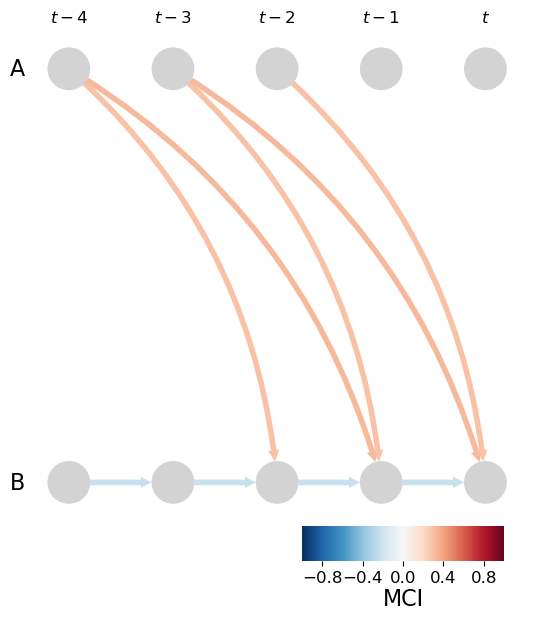

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6.5), dpi=100)

tp.plot_time_series_graph(
    fig_ax=(fig, ax),
    val_matrix=results['val_matrix'],
    graph = results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    label_fontsize=16,
    tick_label_size=12
)

In [9]:
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)

temp_result=saf.get_link_direction(results['p_matrix'], 0.05)
temp_result

array([1, 0])

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)


from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn


ParCorr = parcorr.ParCorr(significance='analytic')

# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10

causal_AB_results = np.zeros((len(causal_strengths), len(lags)))
causal_BA_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        
        # Generate dummy data and linked data
        dummy_data = saf.gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
        dummy_warming_lagged = saf.gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=-lag, tau=13.649751415738818, sigma=0.06633234778696487)
        
        # dummy_warming_lagged = saf.gen_single_directional_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=5e-5, sigma=0.05)
        
        df_checked = GC.make_stationary(dummy_warming_lagged,['A', 'B'], test_method='ADF', plot=False)
        AB_array = df_checked[['A', 'B']].values

        var_names=['A', 'B']
        # Create a Tigramite DataFrame object
        dataframe_sta = pp.DataFrame(AB_array,
                                datatime=np.arange(len(AB_array)),
                                var_names=var_names)


        tau_max=lag+1
        pcmci = PCMCI(
        dataframe=dataframe_sta,
        cond_ind_test=ParCorr,
        verbosity=1)

        pcmci.verbosity = 0
        results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

        p_matrix = results['p_matrix']
        alpha_level = 0.05

        result = saf.get_link_direction(p_matrix, alpha_level)

        causal_AB = result[0]
        causal_BA = result[1]
        
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB
        causal_BA_results[i, j] = causal_BA


causal_results_red_nozscore = np.where((causal_AB_results == 1) & (causal_BA_results == 0), 1, 0)



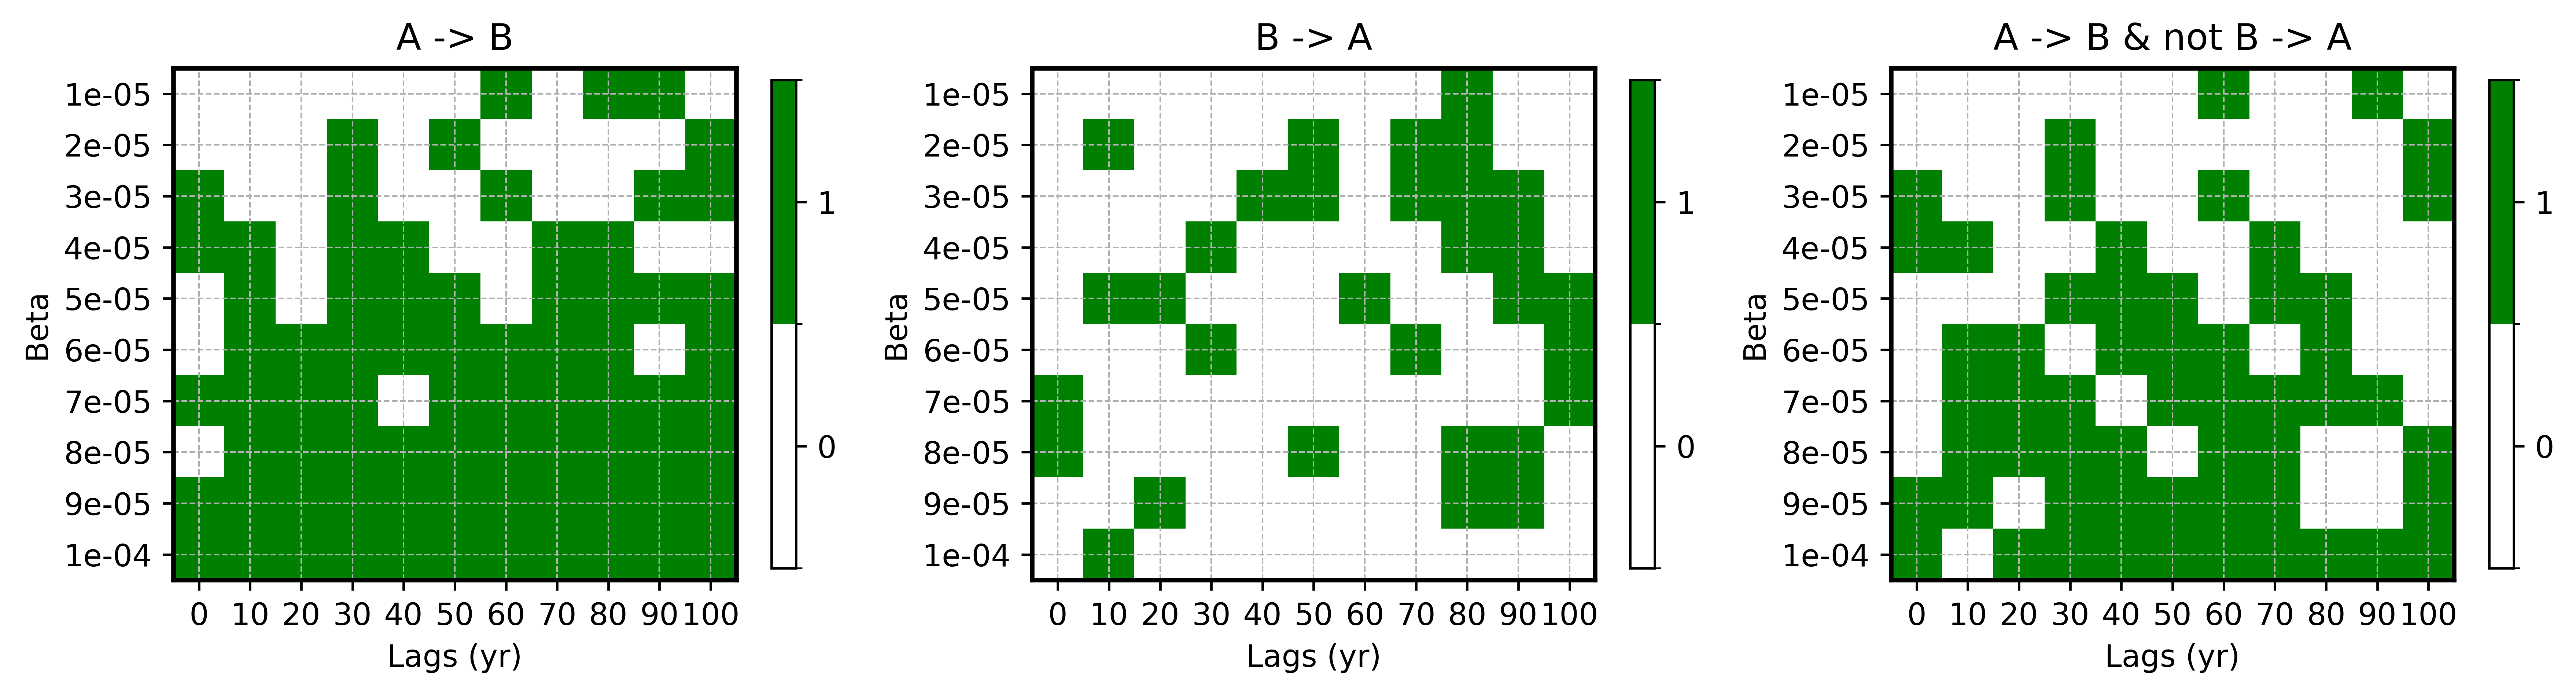

In [15]:
from toolbox import syth_ana_functions as saf
import matplotlib.pyplot as plt
import importlib    
importlib.reload(saf)
import numpy as np

beta = np.arange(1e-5, 1e-4+1e-5, 1e-5)  
lags = range(11)  # From 0 to 10

X=np.array(lags)
Y=np.array(beta)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
saf.causal_matshow_ax(causal_AB_results, axs[0], X=X,Y=Y, title='A -> B', ylabel='Beta')
saf.causal_matshow_ax(causal_BA_results, axs[1], X=X, Y=Y, title='B -> A', ylabel='Beta')

# Assuming causal_results_red_nozscore is derived in your existing code
saf.causal_matshow_ax(causal_results_red_nozscore, axs[2], X=X, Y=Y, title='A -> B & not B -> A', ylabel='Beta')

plt.tight_layout()
plt.show()


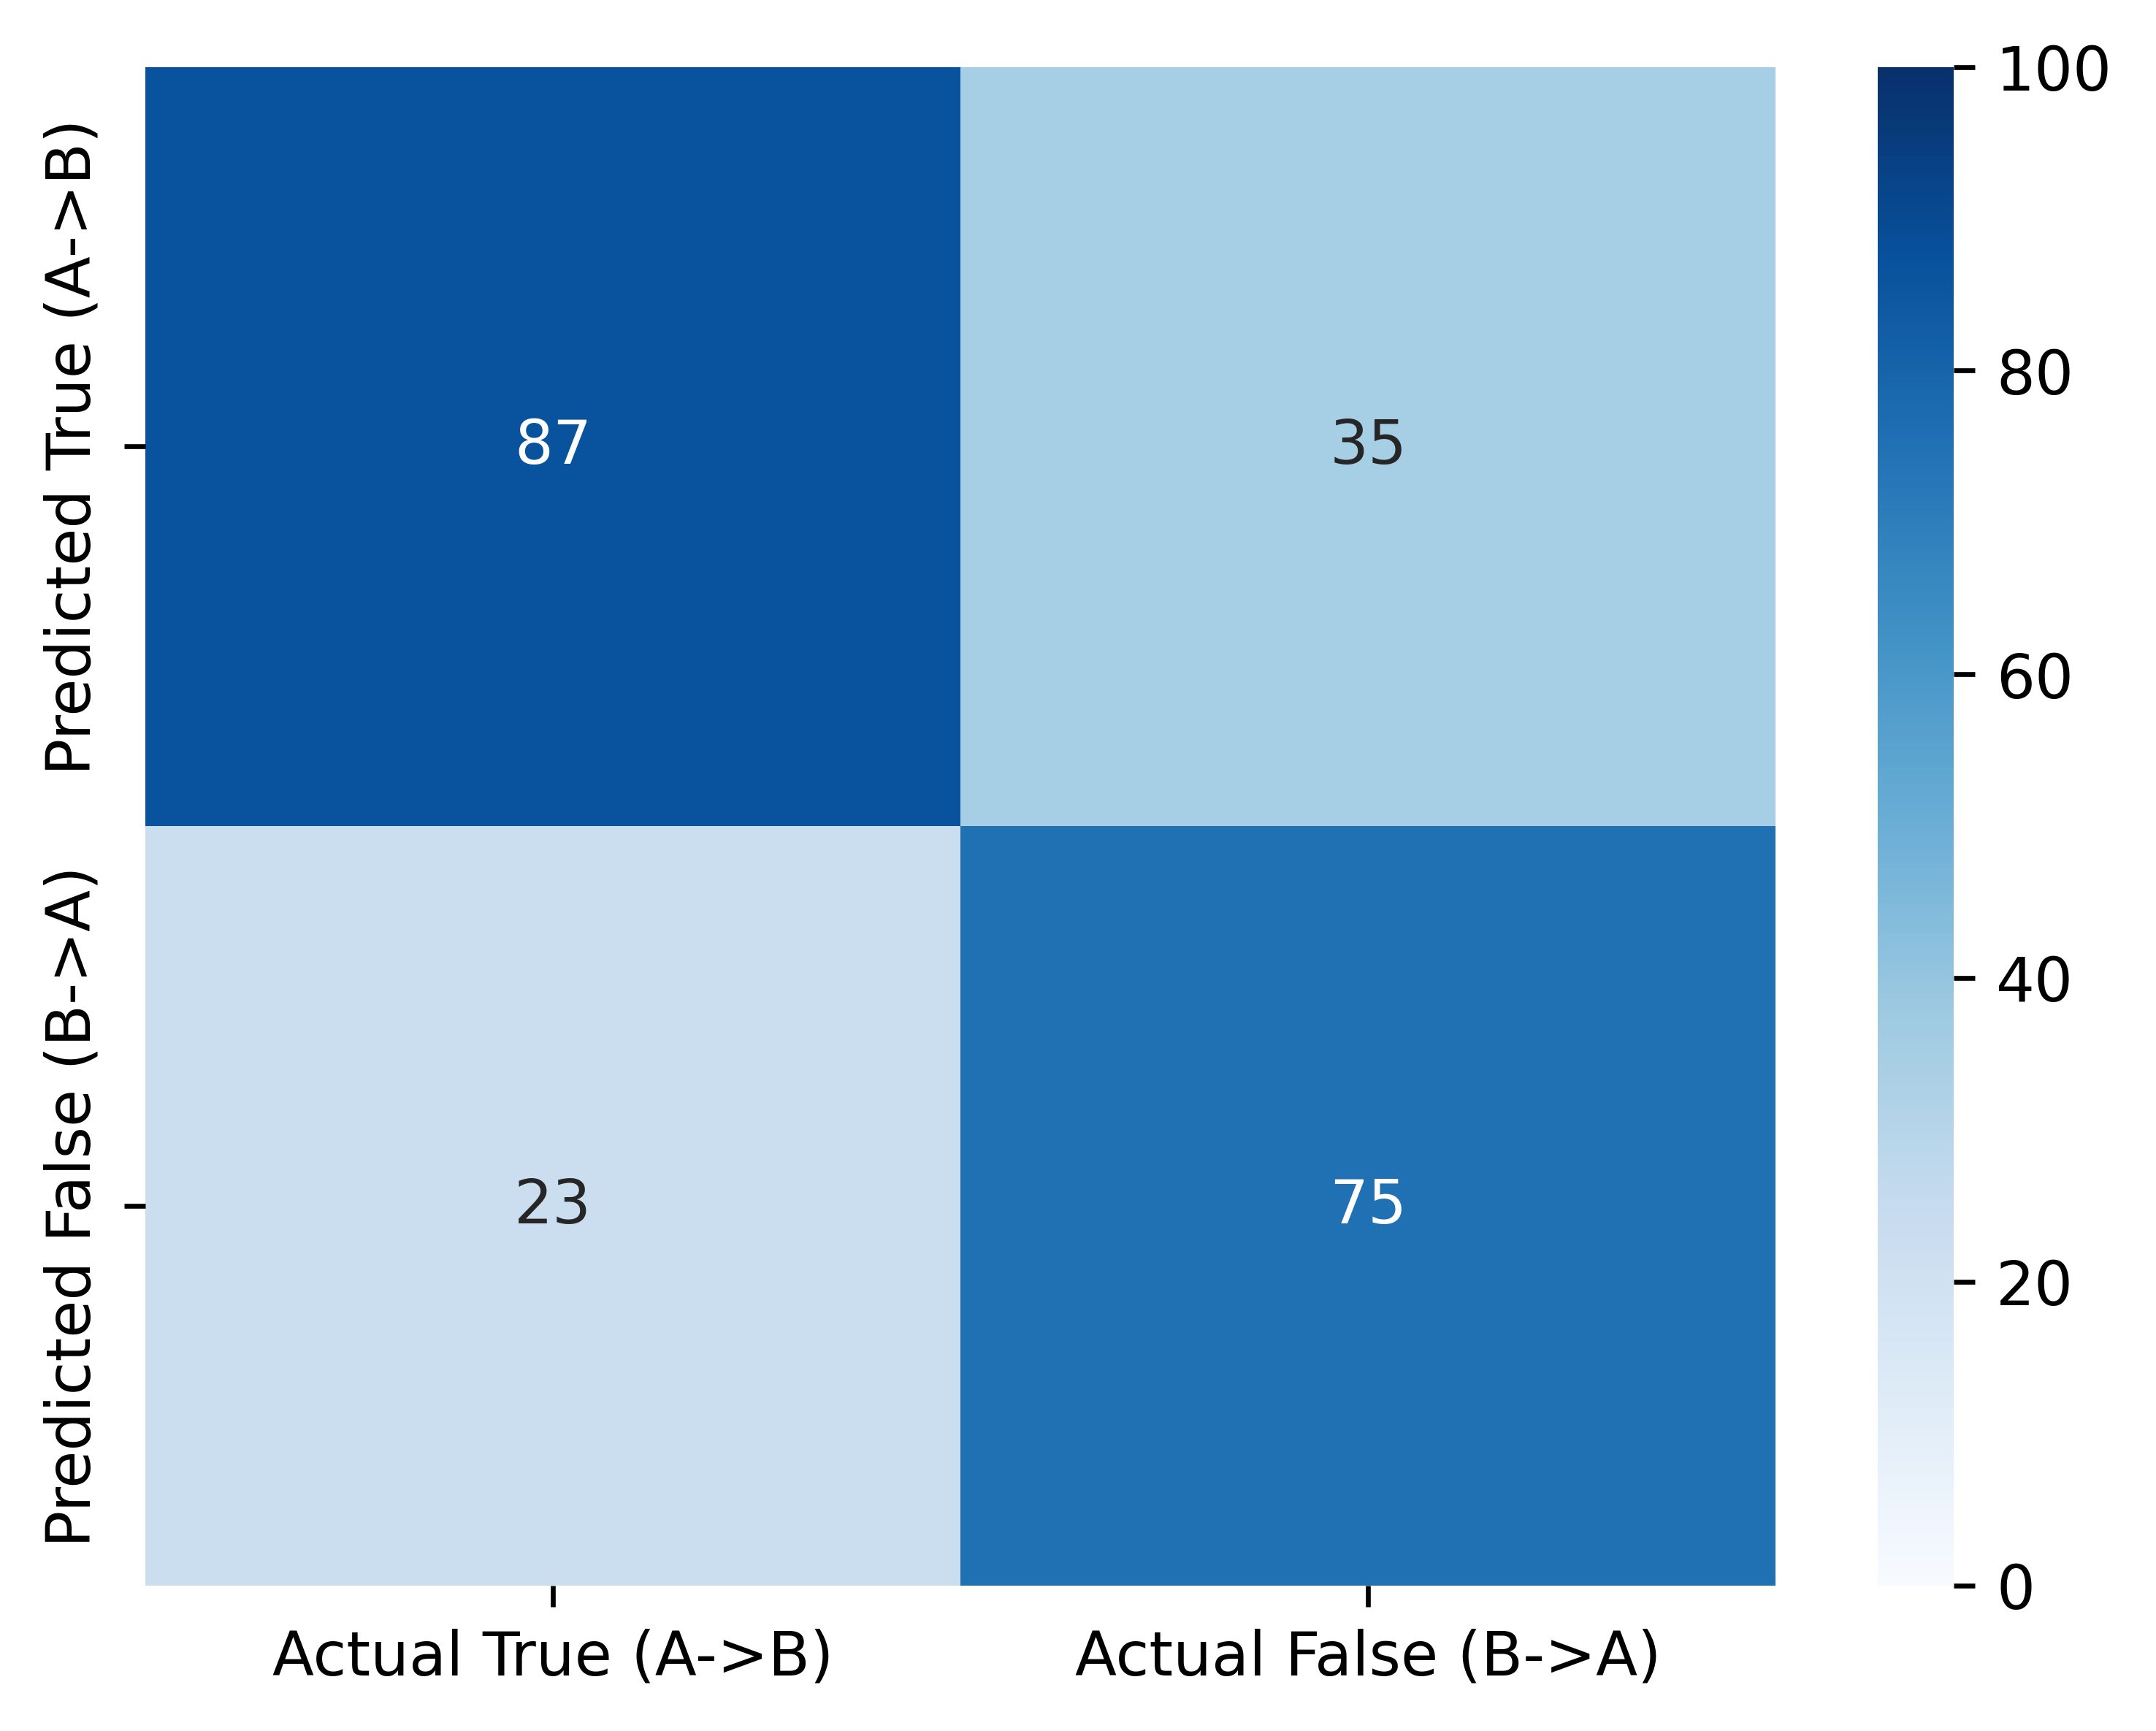

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# True positive for causal_AB_results are the ones, true negative for causal_BA_results are the zeros
true_positives = np.sum(causal_AB_results == 1)
false_negatives = np.sum(causal_AB_results == 0)
true_negatives = np.sum(causal_BA_results == 0)
false_positives = np.sum(causal_BA_results == 1)

# Confusion matrix for A->B vs B->A
conf_matrix = np.array([
    [true_positives, false_positives],
    [false_negatives, true_negatives]
])

# Plot the confusion matrix with the corrected syntax
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=600)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, vmax=100, vmin=0, 
            yticklabels=['Predicted True (A->B)', 'Predicted False (B->A)'],
            xticklabels=['Actual True (A->B)', 'Actual False (B->A)'])
# plt.title('Confusion Matrix for Causal Inference Test Results')
# plt.xlabel('Predicted Condition')
# plt.ylabel('Actual Condition')
plt.show()


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)

# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10

iterations = 20
causal_AB_results = np.zeros((len(causal_strengths), len(lags)))
causal_BA_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            dummy_data = saf.gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            dummy_warming_lagged = saf.gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=-lag, tau=13.649751415738818, sigma=0.06633234778696487)
            
            # dummy_warming_lagged = saf.gen_single_directional_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=5e-5, sigma=0.05)
            
            df_checked = GC.make_stationary(dummy_warming_lagged,['A', 'B'], test_method='ADF', plot=False)
            AB_array = df_checked[['A', 'B']].values

            var_names=['A', 'B']
            # Create a Tigramite DataFrame object
            dataframe_sta = pp.DataFrame(AB_array,
                                    datatime=np.arange(len(AB_array)),
                                    var_names=var_names)


            tau_max=lag+1
            pcmci = PCMCI(
            dataframe=dataframe_sta,
            cond_ind_test=ParCorr,
            verbosity=1)

            pcmci.verbosity = 0
            results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

            p_matrix = results['p_matrix']
            alpha_level = 0.05

            result = saf.get_link_direction(p_matrix, alpha_level)

            causal_AB = result[0]
            causal_BA = result[1]

            
            # causal_AB = np.random.choice([True, False])
            # causal_BA = np.random.choice([True, False])
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95


causal_results_red_nozscore = np.where((causal_AB_results == 1) & (causal_BA_results == 0), 1, 0)



In [10]:
# save the results to D:\VScode\Paleoclimate_causality\syth_test_results
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_oneways_PCMCI.npy', causal_AB_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_oneways_PCMCI.npy', causal_BA_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_oneways_PCMCI.npy', causal_results_red_nozscore)

In [30]:
# read the data
causal_AB_results = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_oneways_PCMCI.npy')
causal_BA_results = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_oneways_PCMCI.npy')
causal_results_red_nozscore = np.load('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_oneways_PCMCI.npy')

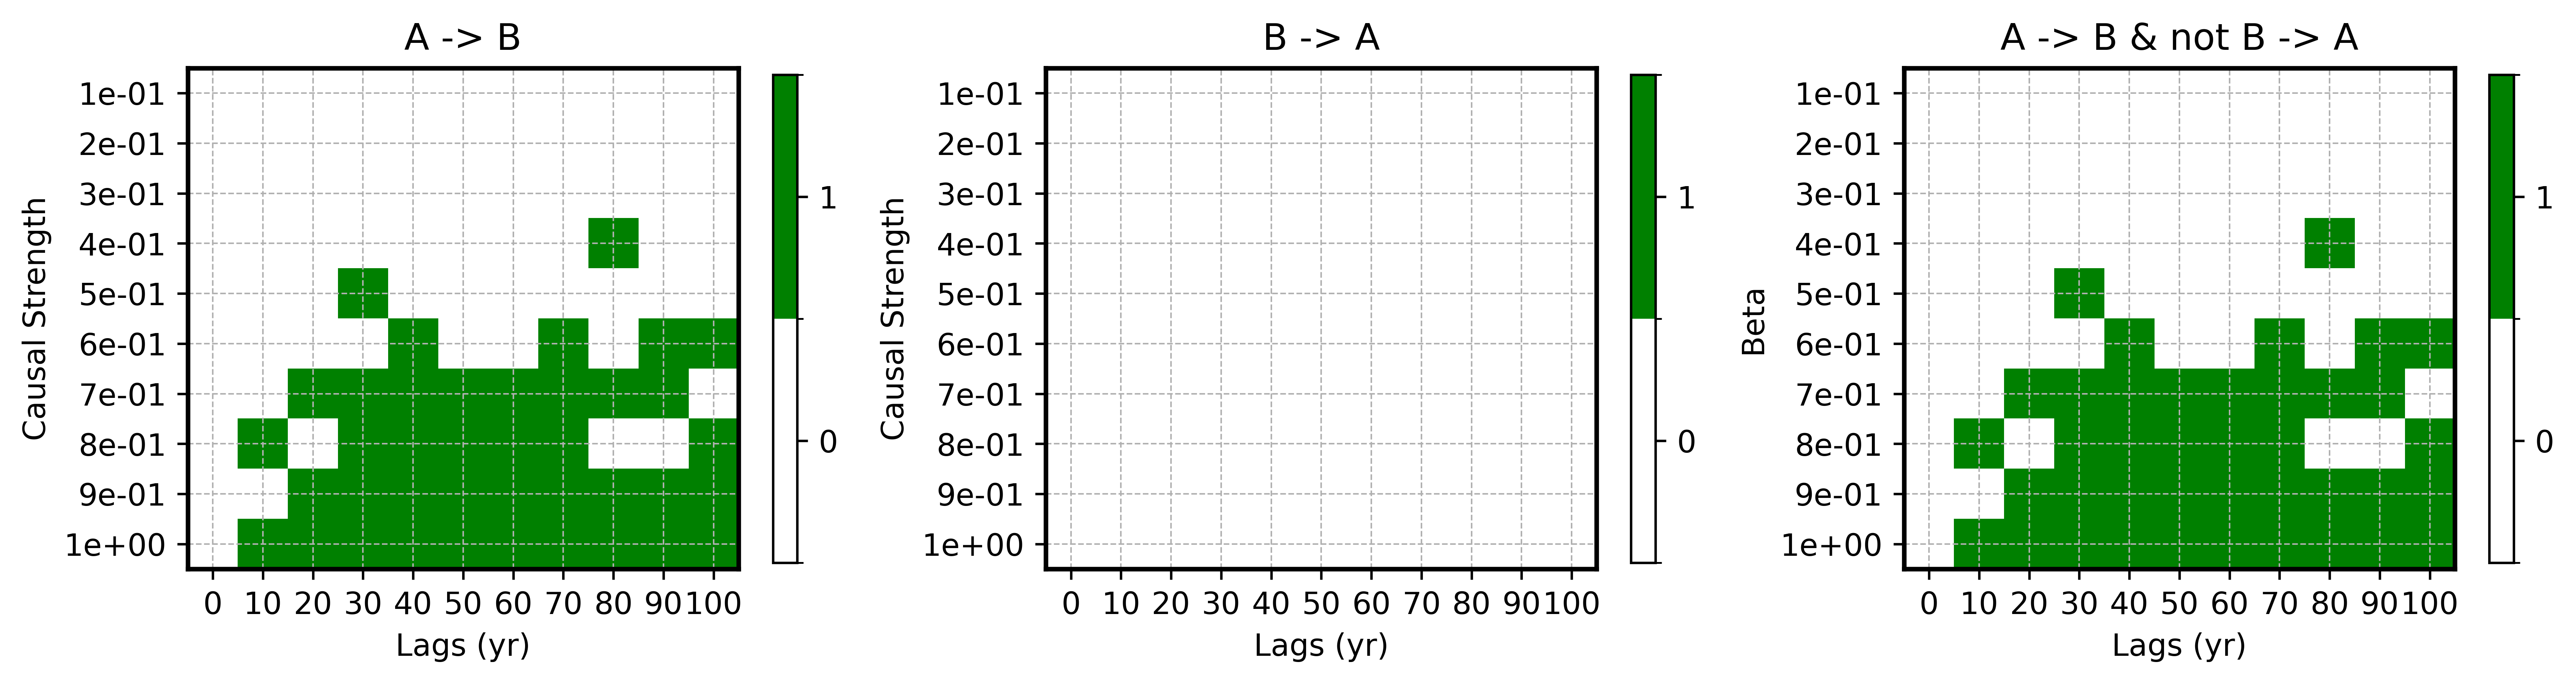

In [33]:
from toolbox import syth_ana_functions as saf
import matplotlib.pyplot as plt
import importlib    
importlib.reload(saf)
import numpy as np

causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10

X=np.array(lags)
Y=np.array(causal_strengths)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
saf.causal_matshow_ax(causal_AB_results, axs[0], X=X,Y=Y, title='A -> B', ylabel='Causal Strength')
saf.causal_matshow_ax(causal_BA_results, axs[1], X=X, Y=Y, title='B -> A', ylabel='Causal Strength')

# Assuming causal_results_red_nozscore is derived in your existing code
saf.causal_matshow_ax(causal_results_red_nozscore, axs[2], X=X, Y=Y, title='A -> B & not B -> A', ylabel='Beta')

plt.tight_layout()
plt.show()

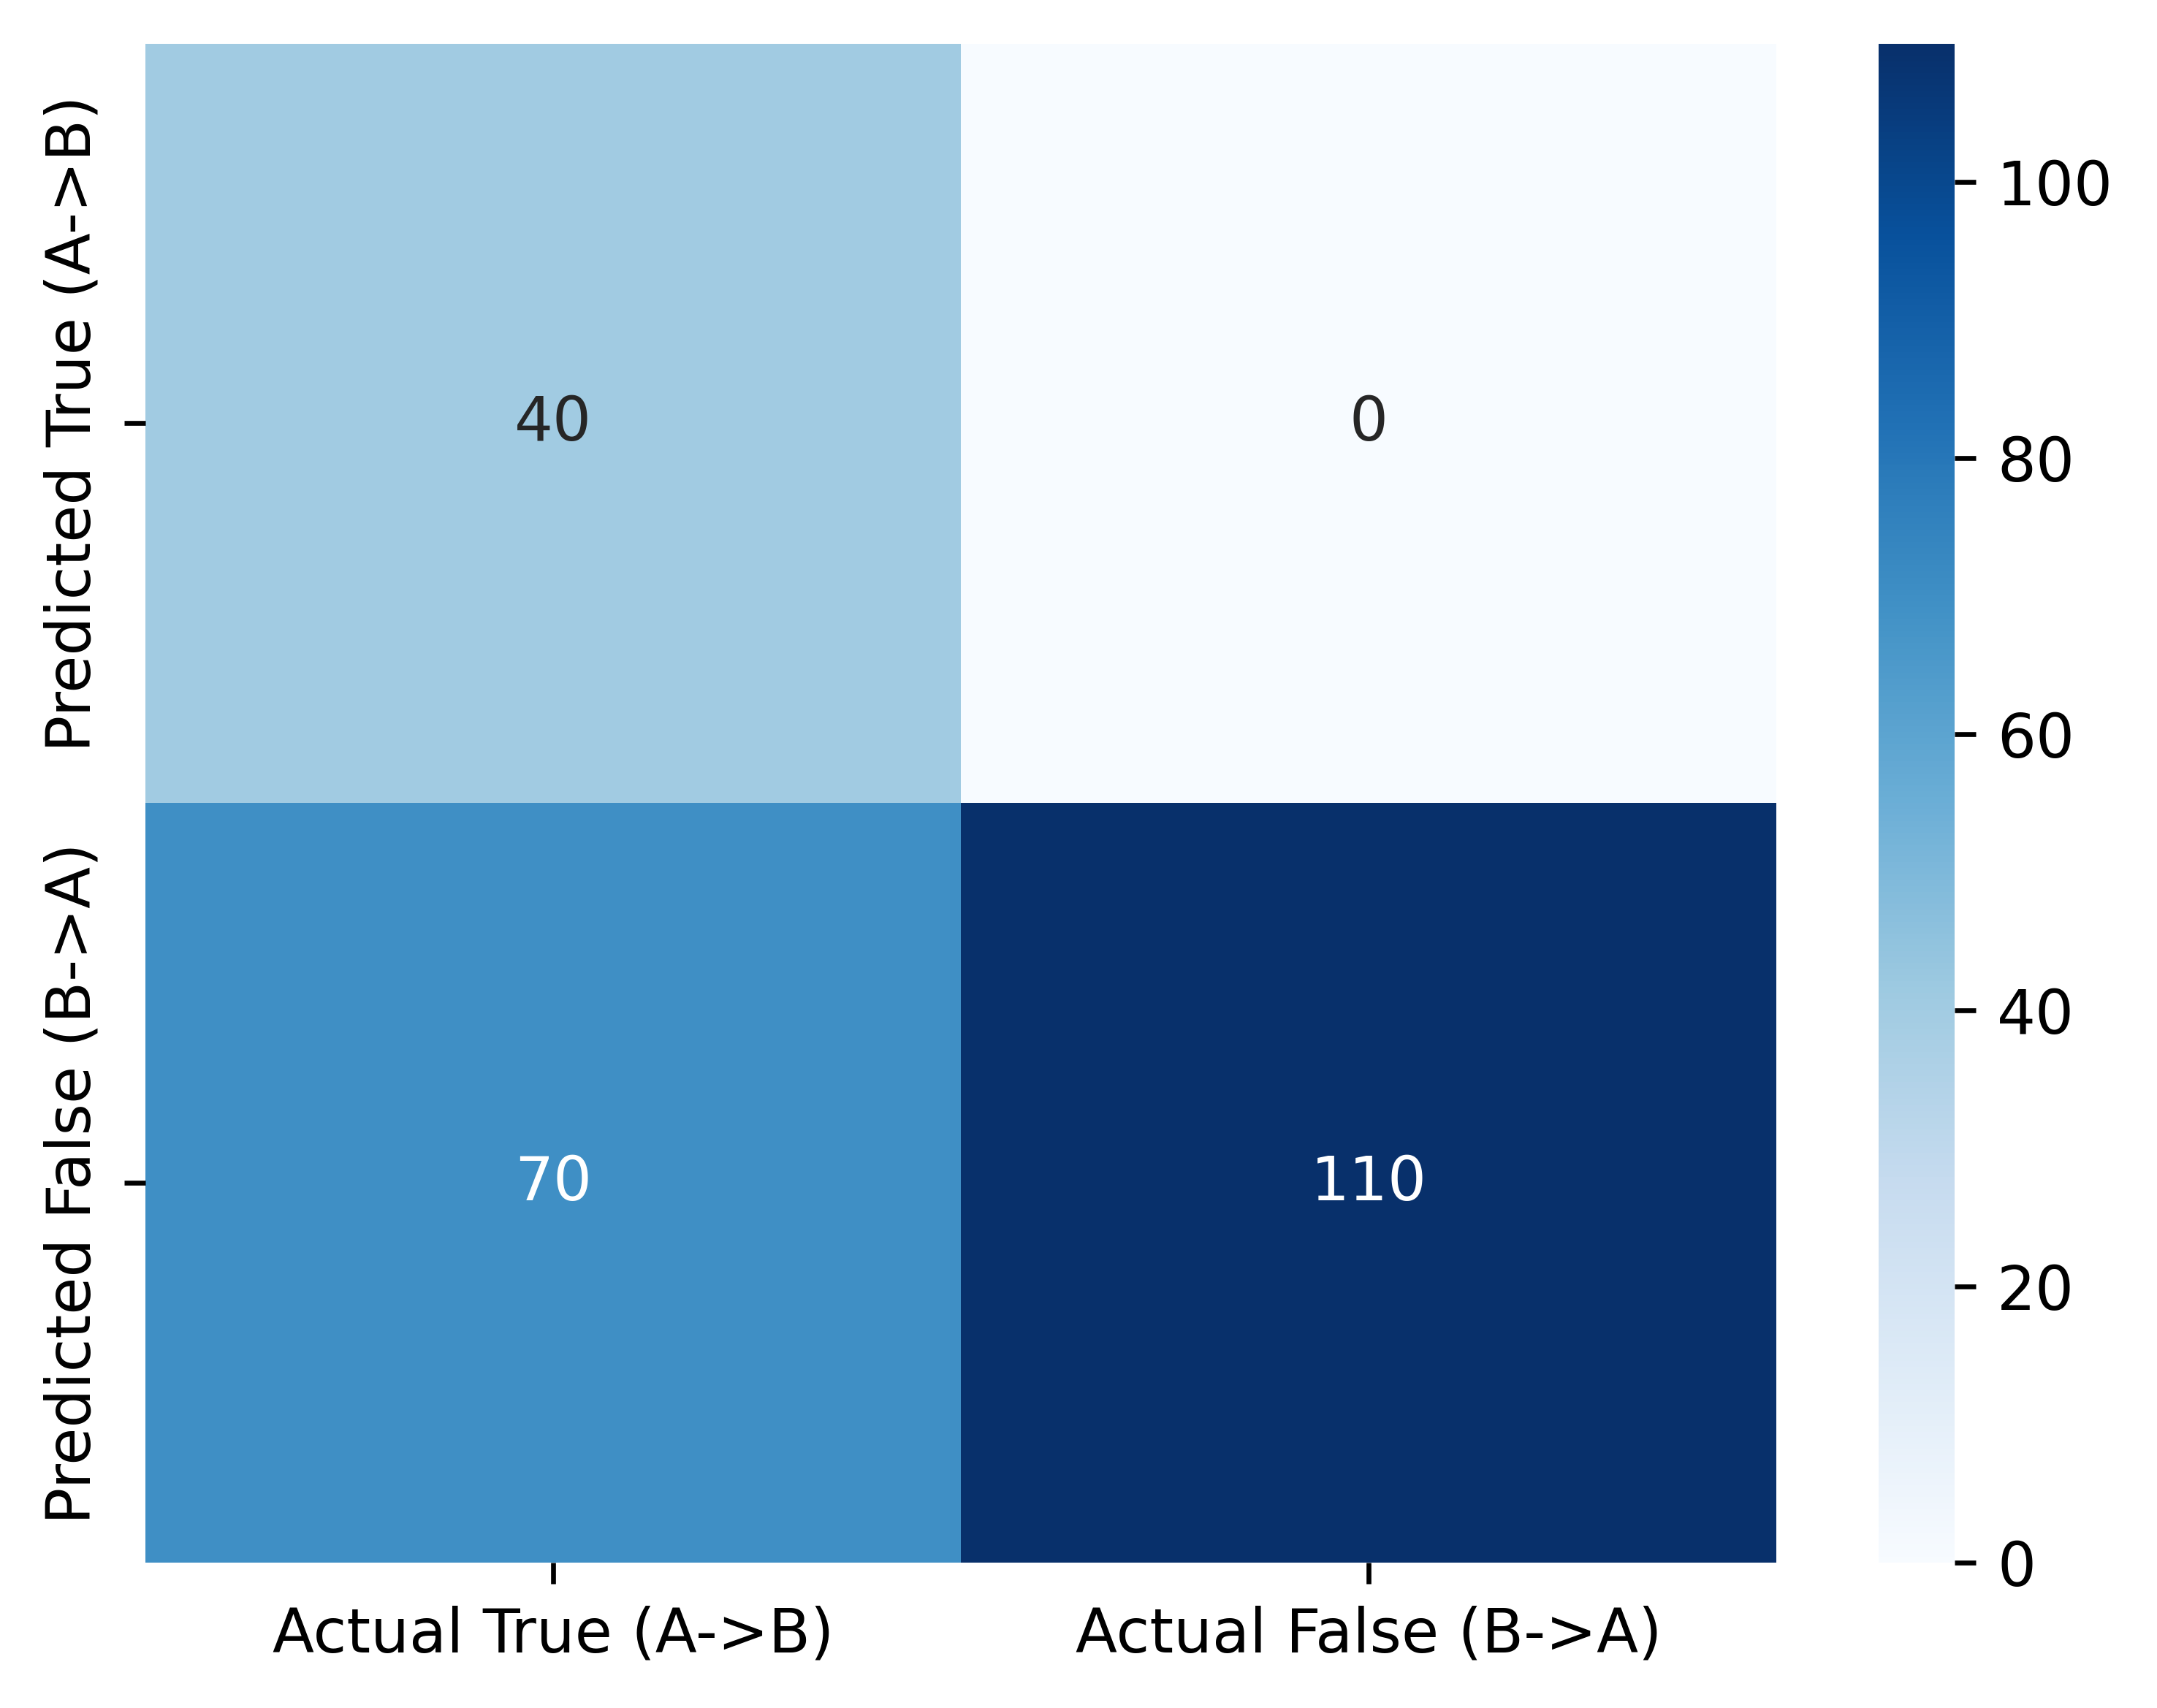

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# True positive for causal_AB_results are the ones, true negative for causal_BA_results are the zeros
true_positives = np.sum(causal_AB_results == 1)
false_negatives = np.sum(causal_AB_results == 0)
true_negatives = np.sum(causal_BA_results == 0)
false_positives = np.sum(causal_BA_results == 1)

# Confusion matrix for A->B vs B->A
conf_matrix = np.array([
    [true_positives, false_positives],
    [false_negatives, true_negatives]
])

# Plot the confusion matrix with the corrected syntax
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=600)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, vmax=110, vmin=0, 
            yticklabels=['Predicted True (A->B)', 'Predicted False (B->A)'],
            xticklabels=['Actual True (A->B)', 'Actual False (B->A)'])
# plt.title('Confusion Matrix for Causal Inference Test Results')
# plt.xlabel('Predicted Condition')
# plt.ylabel('Actual Condition')
plt.show()